# Note

+ Ma khuyen mai duoc su dung nhieu nhat

In [1]:
# from pyspark.sql import functions as f, SparkSession, DataFrame, Window
# from pyspark.sql.functions import col, lit, udf
# from IPython.display import display
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ast
import warnings
import numpy as np
from collections import Counter
import math
from statistics import median
from scipy.stats import skew

warnings.filterwarnings("ignore")
np.set_printoptions(linewidth=1000000)

pd.options.display.float_format = "{:.0f}".format
pd.set_option("display.max_rows", None, "display.max_columns", None)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# import cx_Oracle

# def get_data_from_oracledb(
#     server_ip = '10.22.117.200', SID = 'BIGDATA', port = '1521',
#     user_name = 'PTDL_PTKD', password = 'PTDL_PTKD', sql_query = 'select * from EWVNP1.USER_MAP'):
#     # conn1 = cx_Oracle.connect("VHDVTT/VHDVTT@10.22.117.200:1521/BIGDATA") 
#     conn1 = cx_Oracle.connect(user_name+'/'+password+'@'+server_ip+':'+port+'/'+SID) 
#     cursor1= conn1.cursor()
#     cursor1.execute(sql_query)
#     result = cursor1.fetchall()
#     df = pd.DataFrame(result)
#     field_names = [i[0] for i in cursor1.description]
#     df.columns = field_names
#     return df


# Get data

In [ ]:
# # Bang datamart customer
# query = '''
#     select USER_MAP_ID, TXN_ID, TXN_TYPE, TRANS_TIME, STATUS, TXN_AMOUNT, REAL_AMOUNT, PROMO_AMOUNT, DISCOUNT_AMOUNT, FEE_AMOUNT
#     from DWH_EWVNP.T_FT_TXN_DAILY
#     where SOURCE = 'VAS_TXN'
# '''
# vastxn = get_data_from_oracledb(
#                 sql_query = query, 
#                 server_ip= '10.22.129.11',
#                 SID = 'DWHVNPAY',
#                 user_name='vhdvtt',
#                 password='Vnpay@2022)(*&')

In [3]:
# vastxn = pd.read_csv('data\\vastxn.csv')

vastxn = pd.read_csv('/content/drive/Othercomputers/My Laptop/Desktop/Project Customer Engagement/data/vastxn.csv')


In [ ]:
# cus = pd.read_csv('data\\DIM_CUS2.csv')

In [4]:
# Phan loai GD thanh cong va khong thanh cong
vastxn['SUCCESS_STATUS'] = 0
vastxn.loc[ (vastxn['STATUS'] == 'V2') & (vastxn['STATUS'] == 'V22'), 'SUCCESS_STATUS' ] = 1
vastxn.loc[ (vastxn['STATUS'] == 'V4') & (vastxn['STATUS'] != 'V22'), 'SUCCESS_STATUS' ] = 1


In [5]:
# Lấy tháng năm giao dịch 
vastxn['TRANS_YEAR_MONTH'] = vastxn['TRANS_TIME'].str.slice(0,7)

In [6]:
# convert datetime col
vastxn['TRANS_TIME'] = pd.to_datetime( vastxn['TRANS_TIME'])

In [7]:
# lấy ngày giao dịch
vastxn['TRANS_DATE'] = vastxn['TRANS_TIME'].dt.date
vastxn['TRANS_HOUR'] = vastxn['TRANS_TIME'].dt.hour



In [8]:
# Lay ngay cuoi tuan va trong tuan:
vastxn['TRANS_WEEKDAY'] = vastxn['TRANS_TIME'].dt.weekday
vastxn.loc[vastxn['TRANS_WEEKDAY'] < 5, 'IS_WEEKDAY'] = 1
vastxn.loc[vastxn['TRANS_WEEKDAY'] > 4, 'IS_WEEKEND'] = 1


In [9]:
# Phân loại giao dịch có sử dụng mã khuyến mãi hay không:
vastxn.loc[vastxn['PROMO_AMOUNT'] > 0, 'IS_USINGVOUCHER'] = 1


In [10]:
vastxn.head()

,USER_MAP_ID,TXN_ID,TXN_TYPE,TRANS_TIME,STATUS,TXN_AMOUNT,REAL_AMOUNT,PROMO_AMOUNT,DISCOUNT_AMOUNT,FEE_AMOUNT,SUCCESS_STATUS,TRANS_YEAR_MONTH,TRANS_DATE,TRANS_HOUR,TRANS_WEEKDAY,IS_WEEKDAY,IS_WEEKEND,IS_USINGVOUCHER
0,559990337783996416,560731885223940096,V9,2020-03-27 14:48:19,V4,30000,30000,0,0,0,1,2020-03,2020-03-27,14,4,1,NaN,NaN
1,559990337783996416,560732036118220800,V9,2020-03-27 14:48:55,V4,30000,30000,0,0,0,1,2020-03,2020-03-27,14,4,1,NaN,NaN
2,559990337783996416,560735022349422592,V1,2020-03-27 15:00:47,V4,30000,30000,0,0,0,1,2020-03,2020-03-27,15,4,1,NaN,NaN
3,559990337783996416,560740487284264960,V9,2020-03-27 15:22:30,V4,30000,30000,0,0,0,1,2020-03,2020-03-27,15,4,1,NaN,NaN
4,559990337783996416,561579694932234240,V9,2020-03-29 22:57:13,V4,50000,50000,0,0,0,1,2020-03,2020-03-29,22,6,NaN,1,NaN


In [ ]:
cohortVastxn = vastxn.groupby(["TRANS_YEAR_MONTH","USER_MAP_ID"]).agg({'TXN_ID':'count', 'REAL_AMOUNT':'sum'})
cohortVastxn = cohortVastxn.reset_index()

In [ ]:
cohortVastxn.head()

,TRANS_YEAR_MONTH,USER_MAP_ID,TXN_ID,REAL_AMOUNT
0,2020-03,555308165009514496,21,743000
1,2020-03,555339471202295808,6,467500
2,2020-03,555342520264171520,11,287000
3,2020-03,555343621206056960,41,1734037
4,2020-03,555344579600326656,11,3358090


In [11]:
# get the first trans time per customer
firstCusTrans = vastxn.groupby(['USER_MAP_ID'])['TRANS_TIME'].min().reset_index()
firstCusTrans['firCusTransTime'] = firstCusTrans['TRANS_TIME'].dt.to_period('M')
firstCusTrans.head()

,USER_MAP_ID,TRANS_TIME,firCusTransTime
0,555301097124929536,2020-05-25 21:21:14,2020-05
1,555308165009514496,2020-03-13 11:39:26,2020-03
2,555339471202295808,2020-03-22 10:22:07,2020-03
3,555342520264171520,2020-03-12 20:37:01,2020-03
4,555343621206056960,2020-03-12 21:05:52,2020-03


In [ ]:
# Mapping with cohort
cohortVastxn =pd.merge(
    left = cohortVastxn,
    right = firstCusTrans[['USER_MAP_ID', 'firCusTransTime']],
    how = 'left',
    on = 'USER_MAP_ID'
)

In [ ]:
cohortVastxn.head().info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5 entries, 0 to 4
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype    
---  ------            --------------  -----    
 0   TRANS_YEAR_MONTH  5 non-null      object   
 1   USER_MAP_ID       5 non-null      int64    
 2   TXN_ID            5 non-null      int64    
 3   REAL_AMOUNT       5 non-null      int64    
 4   firCusTransTime   5 non-null      period[M]
 5   cohort_idx        5 non-null      object   
dtypes: int64(3), object(2), period[M](1)
memory usage: 280.0+ bytes


In [ ]:
cohortVastxn['firCusTransTime'] = cohortVastxn['firCusTransTime'].astype('string')

cohortVastxn['firCusTransTime2'] = pd.to_datetime(cohortVastxn['firCusTransTime'] + '-01')
cohortVastxn['TRANS_YEAR_MONTH2'] = pd.to_datetime(cohortVastxn['TRANS_YEAR_MONTH'] + '-01')
cohortVastxn['cohort_idx'] = cohortVastxn['TRANS_YEAR_MONTH2'].dt.to_period('M').astype('int') -\
                              cohortVastxn['firCusTransTime2'].dt.to_period('M').astype('int')
# df.Date2.dt.to_period('M') - df.Date1.dt.to_period('M'),

In [ ]:
cohortVastxn.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2186637 entries, 0 to 2186636
Data columns (total 6 columns):
 #   Column            Dtype 
---  ------            ----- 
 0   TRANS_YEAR_MONTH  object
 1   USER_MAP_ID       int64 
 2   TXN_ID            int64 
 3   REAL_AMOUNT       int64 
 4   firCusTransTime   string
 5   cohort_idx        object
dtypes: int64(3), object(2), string(1)
memory usage: 116.8+ MB


In [ ]:
cohortVastxn.drop(columns = ['firCusTransTime2', 'TRANS_YEAR_MONTH2'], inplace = True)

In [ ]:
cohortVastxn.head()

,TRANS_YEAR_MONTH,USER_MAP_ID,TXN_ID,REAL_AMOUNT,firCusTransTime,cohort_idx,firCusTransTime2,TRANS_YEAR_MONTH2
0,2020-03,555308165009514496,21,743000,2020-03,0,2020-03-01,2020-03-01
1,2020-03,555339471202295808,6,467500,2020-03,0,2020-03-01,2020-03-01
2,2020-03,555342520264171520,11,287000,2020-03,0,2020-03-01,2020-03-01
3,2020-03,555343621206056960,41,1734037,2020-03,0,2020-03-01,2020-03-01
4,2020-03,555344579600326656,11,3358090,2020-03,0,2020-03-01,2020-03-01


In [ ]:
def get_cohort_matrix(data, var='USER_MAP_ID', fun=pd.Series.nunique):
    cd = data.groupby(['firCusTransTime', 'cohort_idx'])[var].apply(fun).reset_index()
    cc = cd.pivot_table(index = 'firCusTransTime',
                        columns = 'cohort_idx',
                        values = var)
    cs = cc.iloc[:,0]
    retention = cc.divide(cs, axis = 0)
    retention = retention.round(3) * 100
    return cc, retention

In [ ]:
cohortNoCustomer, retentionRateCustomer = get_cohort_matrix(cohortVastxn)

# cohort

In [ ]:
cohortNoCustomer.style.background_gradient(cmap='Blues').

cohort_idx,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31
firCusTransTime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-03,154.000000,71.000000,83.000000,86.000000,81.000000,76.000000,82.000000,76.000000,83.000000,95.000000,104.000000,118.000000,120.000000,114.000000,116.000000,116.000000,114.000000,108.000000,110.000000,116.000000,112.000000,112.000000,118.000000,115.000000,112.000000,115.000000,114.000000,117.000000,116.000000,117.000000,116.000000,108.000000
2020-04,425.000000,140.000000,93.000000,85.000000,69.000000,65.000000,54.000000,60.000000,57.000000,60.000000,54.000000,53.000000,55.000000,63.000000,54.000000,58.000000,52.000000,48.000000,57.000000,52.000000,44.000000,50.000000,50.000000,49.000000,51.000000,55.000000,60.000000,61.000000,61.000000,56.000000,43.000000,nan
2020-05,1548.000000,691.000000,534.000000,438.000000,404.000000,365.000000,358.000000,348.000000,318.000000,250.000000,275.000000,225.000000,256.000000,210.000000,207.000000,163.000000,161.000000,166.000000,162.000000,170.000000,191.000000,173.000000,165.000000,187.000000,194.000000,201.000000,197.000000,201.000000,216.000000,128.000000,nan,nan
2020-06,2845.000000,1312.000000,913.000000,784.000000,716.000000,667.000000,631.000000,575.000000,413.000000,401.000000,401.000000,398.000000,357.000000,357.000000,285.000000,237.000000,276.000000,266.000000,237.000000,283.000000,274.000000,253.000000,287.000000,293.000000,313.000000,327.000000,329.000000,330.000000,211.000000,nan,nan,nan
2020-07,3294.000000,1373.000000,1068.000000,902.000000,825.000000,782.000000,679.000000,468.000000,518.000000,495.000000,490.000000,401.000000,377.000000,287.000000,286.000000,323.000000,312.000000,302.000000,360.000000,321.000000,317.000000,336.000000,336.000000,363.000000,389.000000,350.000000,395.000000,219.000000,nan,nan,nan,nan
2020-08,3513.000000,1427.000000,1112.000000,966.000000,913.000000,776.000000,530.000000,559.000000,533.000000,519.000000,448.000000,404.000000,322.000000,268.000000,311.000000,315.000000,299.000000,359.000000,320.000000,287.000000,314.000000,329.000000,347.000000,369.000000,382.000000,391.000000,197.000000,nan,nan,nan,nan,nan
2020-09,4700.000000,1944.000000,1586.000000,1358.000000,1136.000000,757.000000,795.000000,727.000000,727.000000,616.000000,562.000000,431.000000,371.000000,449.000000,445.000000,444.000000,494.000000,409.000000,409.000000,448.000000,483.000000,497.000000,501.000000,519.000000,529.000000,317.000000,nan,nan,nan,nan,nan,nan
2020-10,5193.000000,2364.000000,1869.000000,1433.000000,937.000000,932.000000,867.000000,854.000000,713.000000,650.000000,503.000000,418.000000,515.000000,535.000000,482.000000,576.000000,517.000000,473.000000,498.000000,540.000000,546.000000,589.000000,579.000000,618.000000,338.000000,nan,nan,nan,nan,nan,nan,nan
2020-11,6226.000000,2803.000000,1930.000000,1267.000000,1197.000000,1164.000000,1080.000000,867.000000,854.000000,694.000000,611.000000,711.000000,694.000000,658.000000,747.000000,680.000000,691.000000,717.000000,713.000000,756.000000,778.000000,735.000000,784.000000,435.000000,nan,nan,nan,nan,nan,nan,nan,nan


In [ ]:
retentionRateCustomer.style.background_gradient(cmap='Blues')

cohort_idx,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31
firCusTransTime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-03,100.000000,46.100000,53.900000,55.800000,52.600000,49.400000,53.200000,49.400000,53.900000,61.700000,67.500000,76.600000,77.900000,74.000000,75.300000,75.300000,74.000000,70.100000,71.400000,75.300000,72.700000,72.700000,76.600000,74.700000,72.700000,74.700000,74.000000,76.000000,75.300000,76.000000,75.300000,70.100000
2020-04,100.000000,32.900000,21.900000,20.000000,16.200000,15.300000,12.700000,14.100000,13.400000,14.100000,12.700000,12.500000,12.900000,14.800000,12.700000,13.600000,12.200000,11.300000,13.400000,12.200000,10.400000,11.800000,11.800000,11.500000,12.000000,12.900000,14.100000,14.400000,14.400000,13.200000,10.100000,nan
2020-05,100.000000,44.600000,34.500000,28.300000,26.100000,23.600000,23.100000,22.500000,20.500000,16.100000,17.800000,14.500000,16.500000,13.600000,13.400000,10.500000,10.400000,10.700000,10.500000,11.000000,12.300000,11.200000,10.700000,12.100000,12.500000,13.000000,12.700000,13.000000,14.000000,8.300000,nan,nan
2020-06,100.000000,46.100000,32.100000,27.600000,25.200000,23.400000,22.200000,20.200000,14.500000,14.100000,14.100000,14.000000,12.500000,12.500000,10.000000,8.300000,9.700000,9.300000,8.300000,9.900000,9.600000,8.900000,10.100000,10.300000,11.000000,11.500000,11.600000,11.600000,7.400000,nan,nan,nan
2020-07,100.000000,41.700000,32.400000,27.400000,25.000000,23.700000,20.600000,14.200000,15.700000,15.000000,14.900000,12.200000,11.400000,8.700000,8.700000,9.800000,9.500000,9.200000,10.900000,9.700000,9.600000,10.200000,10.200000,11.000000,11.800000,10.600000,12.000000,6.600000,nan,nan,nan,nan
2020-08,100.000000,40.600000,31.700000,27.500000,26.000000,22.100000,15.100000,15.900000,15.200000,14.800000,12.800000,11.500000,9.200000,7.600000,8.900000,9.000000,8.500000,10.200000,9.100000,8.200000,8.900000,9.400000,9.900000,10.500000,10.900000,11.100000,5.600000,nan,nan,nan,nan,nan
2020-09,100.000000,41.400000,33.700000,28.900000,24.200000,16.100000,16.900000,15.500000,15.500000,13.100000,12.000000,9.200000,7.900000,9.600000,9.500000,9.400000,10.500000,8.700000,8.700000,9.500000,10.300000,10.600000,10.700000,11.000000,11.300000,6.700000,nan,nan,nan,nan,nan,nan
2020-10,100.000000,45.500000,36.000000,27.600000,18.000000,17.900000,16.700000,16.400000,13.700000,12.500000,9.700000,8.000000,9.900000,10.300000,9.300000,11.100000,10.000000,9.100000,9.600000,10.400000,10.500000,11.300000,11.100000,11.900000,6.500000,nan,nan,nan,nan,nan,nan,nan
2020-11,100.000000,45.000000,31.000000,20.400000,19.200000,18.700000,17.300000,13.900000,13.700000,11.100000,9.800000,11.400000,11.100000,10.600000,12.000000,10.900000,11.100000,11.500000,11.500000,12.100000,12.500000,11.800000,12.600000,7.000000,nan,nan,nan,nan,nan,nan,nan,nan


In [ ]:
retentionRateCustomer = retentionRateCustomer/100

In [ ]:
def get_cohort_matrix2(data, var='USER_MAP_ID', fun=pd.Series.sum):
    cd = data.groupby(['firCusTransTime', 'TRANS_YEAR_MONTH'])[var].apply(fun).reset_index()
    cc = cd.pivot_table(index = 'firCusTransTime',
                        columns = 'TRANS_YEAR_MONTH',
                        values = var)
    cs = cc.iloc[:,0]
    retention = cc.divide(cs, axis = 0)
    retention = retention.round(3) * 100
    return cc, retention

In [ ]:
CorhortTotalAmount, retention2 = get_cohort_matrix2(cohortVastxn, var = 'REAL_AMOUNT')

In [ ]:
CorhortTotalAmount.style.background_gradient(cmap='Blues')


TRANS_YEAR_MONTH,2020-03,2020-04,2020-05,2020-06,2020-07,2020-08,2020-09,2020-10,2020-11,2020-12,2021-01,2021-02,2021-03,2021-04,2021-05,2021-06,2021-07,2021-08,2021-09,2021-10,2021-11,2021-12,2022-01,2022-02,2022-03,2022-04,2022-05,2022-06,2022-07,2022-08,2022-09,2022-10
firCusTransTime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-03,99851957.000000,76423377.000000,148143591.000000,180723235.000000,191251356.000000,128008491.000000,137552922.000000,151682225.000000,224162129.000000,233125806.000000,436941456.000000,421652957.000000,455144209.000000,519677837.000000,422349888.000000,435497940.000000,474643506.000000,285778520.000000,356965334.000000,474790217.000000,484293638.000000,529695770.000000,722087676.000000,455539445.000000,617514874.000000,695773841.000000,682161778.000000,760158006.000000,828922332.000000,874841503.000000,923730345.000000,216621177.000000
2020-04,nan,474027835.000000,159487406.000000,152224881.000000,83083038.000000,88088190.000000,81000117.000000,64132586.000000,86259573.000000,84354004.000000,221909263.000000,139147373.000000,147768886.000000,163249469.000000,274129870.000000,215622805.000000,190233713.000000,117195330.000000,119795611.000000,200532777.000000,142638899.000000,160365001.000000,177026303.000000,172667017.000000,170473694.000000,177434561.000000,212804799.000000,475204210.000000,290868982.000000,340150630.000000,316946001.000000,111442303.000000
2020-05,nan,nan,1293044346.000000,780792697.000000,611327610.000000,455457210.000000,462423043.000000,500115037.000000,456085989.000000,524834926.000000,578682028.000000,465457587.000000,554428852.000000,523712699.000000,687582893.000000,491579808.000000,466724768.000000,337270168.000000,370361002.000000,511511242.000000,528839900.000000,502460851.000000,700481537.000000,394305957.000000,434233463.000000,537176968.000000,571945358.000000,678797588.000000,664990849.000000,816998435.000000,916098926.000000,233140873.000000
2020-06,nan,nan,nan,3030501578.000000,1558868923.000000,961375697.000000,864127563.000000,840990205.000000,830156134.000000,885490655.000000,1047366331.000000,674920454.000000,734978073.000000,784622580.000000,877811382.000000,652166985.000000,669275194.000000,488156581.000000,421416732.000000,534270329.000000,698907670.000000,613668597.000000,779893479.000000,661298340.000000,564630009.000000,631154346.000000,695368626.000000,801397876.000000,945817038.000000,1177656023.000000,1074179080.000000,415627110.000000
2020-07,nan,nan,nan,nan,2769054725.000000,1147303923.000000,999686466.000000,907184859.000000,897320933.000000,932825458.000000,942571437.000000,554615114.000000,655575910.000000,742979362.000000,862561035.000000,736510247.000000,676394505.000000,404979369.000000,494685244.000000,544615326.000000,533825315.000000,571740868.000000,720137866.000000,642015419.000000,526077080.000000,687694950.000000,705762216.000000,886748903.000000,1054049568.000000,1070770465.000000,1323265227.000000,385883159.000000
2020-08,nan,nan,nan,nan,nan,2775400208.000000,1263491606.000000,1038527070.000000,1004083966.000000,1038908375.000000,1019420181.000000,641239428.000000,687055944.000000,729485110.000000,832565516.000000,774463614.000000,599408044.000000,511365549.000000,433486750.000000,558715561.000000,717498338.000000,601176218.000000,785270695.000000,436331232.000000,437866943.000000,638853539.000000,686928991.000000,588665814.000000,1000428680.000000,982297219.000000,1128698162.000000,288077620.000000
2020-09,nan,nan,nan,nan,nan,nan,4028781289.000000,1605368631.000000,1484064317.000000,1321833152.000000,1464286568.000000,902762309.000000,848109816.000000,1045206871.000000,1544670191.000000,984748078.000000,940176820.000000,635665508.000000,574305367.000000,591795362.000000,878134410.000000,609127397.000000,919180705.000000,662843643.000000,650295360.000000,964639864.000000,941412870.000000,1150912874.000000,1774709247.000000,1523827169.000000,1439654177.000000,459379573.000000
2020-10,nan,nan,nan,nan,nan,nan,nan,4718334605.000000,1933850366.0

In [ ]:
CorhortTotalAmount.reset_index().to_excel('./CohortTotalAmount1.xlsx', index = False)

In [ ]:
retentionRateCustomer.reset_index().to_excel('./CohortRetentionRateNoCus.xlsx', index = False)


In [ ]:
cohortNoCustomer.reset_index().to_excel('./CohortNoCus.xlsx', index = False)


In [ ]:
cohortTotalAmount, cohortRetentionRateAmount = get_cohort_matrix(cohortVastxn, 'REAL_AMOUNT', fun=pd.Series.sum)


In [ ]:
cohortTotalAmount.reset_index().to_excel('./cohortTotalAmount.xlsx', index = False)
cohortRetentionRateAmount.reset_index().to_excel('./cohortRetentionRateAmount.xlsx', index = False)


# promotion new abd old

In [51]:
vastxn.head()

,USER_MAP_ID,TXN_ID,TXN_TYPE,TRANS_TIME,STATUS,TXN_AMOUNT,REAL_AMOUNT,PROMO_AMOUNT,DISCOUNT_AMOUNT,FEE_AMOUNT,SUCCESS_STATUS,TRANS_YEAR_MONTH,TRANS_DATE,TRANS_HOUR,TRANS_WEEKDAY,IS_WEEKDAY,IS_WEEKEND,IS_USINGVOUCHER,firstTransTime,isFirstTrans
0,559990337783996416,560731885223940096,V9,2020-03-27 14:48:19,V4,30000,30000,0,0,0,1,2020-03,2020-03-27,14,4,1,NaN,NaN,2020-03-26 16:26:58,Old customer
1,559990337783996416,560732036118220800,V9,2020-03-27 14:48:55,V4,30000,30000,0,0,0,1,2020-03,2020-03-27,14,4,1,NaN,NaN,2020-03-26 16:26:58,Old customer
2,559990337783996416,560735022349422592,V1,2020-03-27 15:00:47,V4,30000,30000,0,0,0,1,2020-03,2020-03-27,15,4,1,NaN,NaN,2020-03-26 16:26:58,Old customer
3,559990337783996416,560740487284264960,V9,2020-03-27 15:22:30,V4,30000,30000,0,0,0,1,2020-03,2020-03-27,15,4,1,NaN,NaN,2020-03-26 16:26:58,Old customer
4,559990337783996416,561579694932234240,V9,2020-03-29 22:57:13,V4,50000,50000,0,0,0,1,2020-03,2020-03-29,22,6,NaN,1,NaN,2020-03-26 16:26:58,Old customer


In [18]:
firstCusTrans.rename(columns = {'TRANS_TIME': 'firstTransTime'}, inplace = True)

In [19]:
# maping lay ngay GD dau tien
vastxn = pd.merge(
    left =  vastxn,
    right = firstCusTrans[['USER_MAP_ID', 'firstTransTime']],
    how = 'left',
    on = 'USER_MAP_ID'
)

In [26]:
# Mark first trans
vastxn['isFirstTrans'] = 'Old customer'
vastxn.loc[vastxn['TRANS_TIME'] == vastxn['firstTransTime'], 'isFirstTrans'] = 'New customer'


In [52]:
# Gia tri trung binh KM/trans New customer and Old customer
promNewcusTime = vastxn[vastxn['SUCCESS_STATUS']==1].groupby(['TRANS_YEAR_MONTH','isFirstTrans'])['PROMO_AMOUNT'].mean().reset_index()

In [ ]:
# Hieu so 

In [54]:
promNewcusTime2 = promNewcusTime.pivot(
    index = 'TRANS_YEAR_MONTH',
    columns = 'isFirstTrans',
    values = 'PROMO_AMOUNT'
).reset_index()

In [55]:
promNewcusTime2['Chenh lech'] = promNewcusTime2['New customer'] - promNewcusTime2['Old customer']

In [49]:
promNewcusTime2.head()

isFirstTrans,TRANS_YEAR_MONTH,New customer,Old customer,Chenh lech
0,2020-03,1052,1127,-75
1,2020-04,6087,3355,2732
2,2020-05,16484,12450,4034
3,2020-06,22334,17485,4849
4,2020-07,19427,16293,3134


In [41]:
promNewcusTime.head()

,TRANS_YEAR_MONTH,isFirstTrans,PROMO_AMOUNT
0,2020-03,New customer,1052
1,2020-03,Old customer,1127
2,2020-04,New customer,6087
3,2020-04,Old customer,3355
4,2020-05,New customer,16484


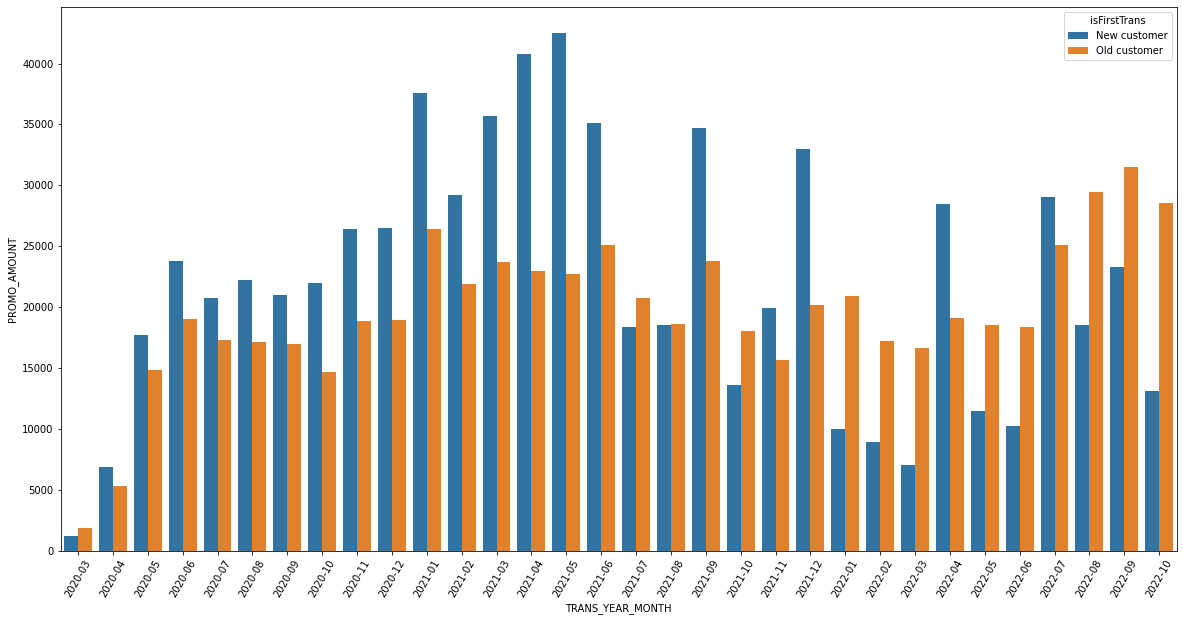

In [56]:
plt.figure(figsize = (20,10))

sns.barplot(
    data = promNewcusTime,
    x = 'TRANS_YEAR_MONTH',
    y = 'PROMO_AMOUNT',
    hue = 'isFirstTrans'
)
plt.xticks(rotation = 60)

plt.show()

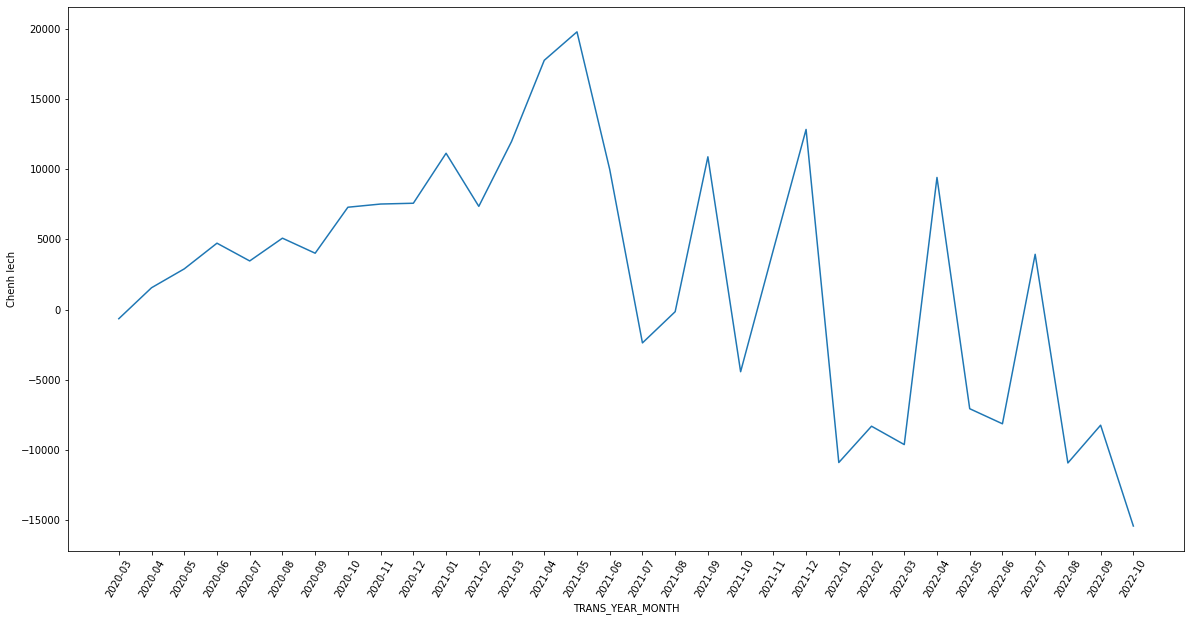

In [57]:
plt.figure(figsize = (20,10))

sns.lineplot(
    data = promNewcusTime2,
    x = 'TRANS_YEAR_MONTH',
    y = 'Chenh lech'
)
plt.xticks(rotation = 60)

plt.show()

In [58]:
# % Giao dich khach hang moi va khach hang cu trong cac thang
sucTrans = vastxn[vastxn['SUCCESS_STATUS'] == 1]


In [66]:
cusTypeCount = sucTrans.groupby(['TRANS_YEAR_MONTH', 'isFirstTrans'])['USER_MAP_ID'].nunique().reset_index()
cusTypeCount2 = cusTypeCount.pivot(
                  index = 'TRANS_YEAR_MONTH',
                  columns = 'isFirstTrans',
                  values = 'USER_MAP_ID'
).reset_index()

In [67]:
cusTypeCount.head()

,TRANS_YEAR_MONTH,isFirstTrans,USER_MAP_ID
0,2020-03,New customer,131
1,2020-03,Old customer,88
2,2020-04,New customer,376
3,2020-04,Old customer,185
4,2020-05,New customer,1439


In [68]:
cusTypeCount2.head()

isFirstTrans,TRANS_YEAR_MONTH,New customer,Old customer
0,2020-03,131,88
1,2020-04,376,185
2,2020-05,1439,836
3,2020-06,2673,2086
4,2020-07,3084,3475


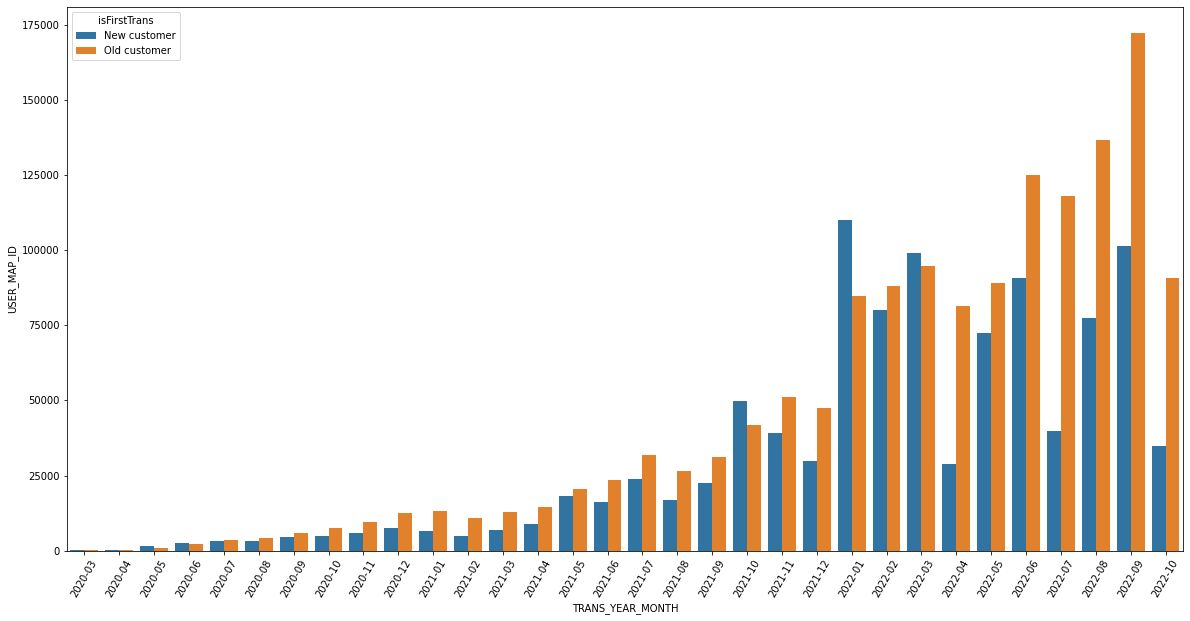

In [69]:
plt.figure(figsize = (20,10))

sns.barplot(
    data = cusTypeCount,
    x = 'TRANS_YEAR_MONTH',
    y = 'USER_MAP_ID',
    hue = 'isFirstTrans'
)
plt.xticks(rotation = 60)

plt.show()

In [21]:
vastxn.drop(columns = 'firCusTransTime', inplace = True)


In [59]:
vastxn.sample(5)

,USER_MAP_ID,TXN_ID,TXN_TYPE,TRANS_TIME,STATUS,TXN_AMOUNT,REAL_AMOUNT,PROMO_AMOUNT,DISCOUNT_AMOUNT,FEE_AMOUNT,SUCCESS_STATUS,TRANS_YEAR_MONTH,TRANS_DATE,TRANS_HOUR,TRANS_WEEKDAY,IS_WEEKDAY,IS_WEEKEND,IS_USINGVOUCHER,firstTransTime,isFirstTrans
5407135,876130317273415680,888005527296327680,V9,2022-09-16 17:16:56,V4,510000,490000,20000,0,0,1,2022-09,2022-09-16,17,4,1,NaN,1,2022-08-22 10:43:33,Old customer
306114,587918198016851968,685396190547808256,V9,2021-03-06 14:59:45,V4,150000,150000,0,0,0,1,2021-03,2021-03-06,14,5,NaN,1,NaN,2020-06-13 15:23:13,Old customer
4049840,732438675564544000,864450477507612672,V9,2022-07-13 17:17:33,V4,908000,808000,100000,0,0,1,2022-07,2022-07-13,17,2,1,NaN,1,2021-07-16 18:25:19,Old customer
4830059,567186069318279168,879221130194456576,V9,2022-08-23 11:30:52,V4,153000,107000,46000,0,0,1,2022-08,2022-08-23,11,1,1,NaN,1,2021-02-07 20:47:09,Old customer
1144557,775926079180783616,775947007985586176,V2,2021-11-11 11:56:23,V1,20000,20000,0,0,0,0,2021-11,2021-11-11,11,3,1,NaN,NaN,2021-11-11 11:56:23,New customer


In [16]:
firstCusTrans.head()

,USER_MAP_ID,TRANS_TIME,firCusTransTime
0,555301097124929536,2020-05-25 21:21:14,2020-05
1,555308165009514496,2020-03-13 11:39:26,2020-03
2,555339471202295808,2020-03-22 10:22:07,2020-03
3,555342520264171520,2020-03-12 20:37:01,2020-03
4,555343621206056960,2020-03-12 21:05:52,2020-03
